## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

# Helper Functions

In [2]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

## Data Generator

In [77]:
def generate_loop_wave_data(total_duration_ms, num_loops, rows, cols, overlap_duration_ms, break_duration_ms):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_loops - 1))
    loop_duration_ms = adjusted_total_duration_ms / num_loops

    center_x, center_y = (rows - 1) / 2, (cols - 1) / 2
    max_distance = np.sqrt((center_x) ** 2 + (center_y) ** 2)
    circle_radius = max_distance / 2  # Assuming the circle is at half the max distance
    thickness = 2  # Thickness of the circle in neurons

    # Initialize positions
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    distances = [np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) for x, y in positions]
    angles = [np.arctan2(y - center_y, x - center_x) for x, y in positions]

    # Filter positions for those on the circle and sort them by angle
    circle_positions = [(index, pos, dist, angle) for index, (pos, dist, angle) in enumerate(zip(positions, distances, angles))
                        if circle_radius - thickness <= dist <= circle_radius + thickness]
    circle_positions_sorted = sorted(circle_positions, key=lambda x: x[3])  # Sort by angle

    # Initialize train with empty lists for each channel
    train_loop_wave = [[] for _ in range(N_channels)]

    # Generate spike times for neurons on the circle
    for loop in range(num_loops):
        loop_start = loop * (loop_duration_ms + break_duration_ms)
        for i, (neuron_index, _, _, _) in enumerate(circle_positions_sorted):
            # Calculate firing time based on position in sequence
            position_in_sequence = i / len(circle_positions_sorted)
            firing_time_within_loop = position_in_sequence * (loop_duration_ms - overlap_duration_ms)
            spike_time_start = loop_start + firing_time_within_loop
            spike_time_end = spike_time_start + overlap_duration_ms
            spike_times = np.linspace(spike_time_start, spike_time_end, int(overlap_duration_ms / 10))

            train_loop_wave[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays
    train_loop_wave = [np.array(times) for times in train_loop_wave]

    # Initialize neuron_data with positions
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Assume SpikeData is defined elsewhere
    spike_data_loop_wave = SpikeData(train=train_loop_wave, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_loop_wave

def generate_continuous_loop_wave_data(total_duration_ms, num_loops, rows, cols, overlap_duration_ms):
    N_channels = rows * cols
    # Since there are no breaks, the total duration directly dictates the duration per loop
    loop_duration_ms = total_duration_ms / num_loops

    center_x, center_y = (rows - 1) / 2, (cols - 1) / 2
    max_distance = np.sqrt((center_x) ** 2 + (center_y) ** 2)
    circle_radius = max_distance / 2  # Assuming the circle is at half the max distance
    thickness = 2  # Thickness of the circle in neurons

    # Initialize positions
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    distances = [np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) for x, y in positions]
    angles = [np.arctan2(y - center_y, x - center_x) for x, y in positions]

    # Filter positions for those on the circle and sort them by angle
    circle_positions = [(index, pos, dist, angle) for index, (pos, dist, angle) in enumerate(zip(positions, distances, angles))
                        if circle_radius - thickness <= dist <= circle_radius + thickness]
    circle_positions_sorted = sorted(circle_positions, key=lambda x: x[3])  # Sort by angle

    # Initialize train with empty lists for each channel
    train_loop_wave = [[] for _ in range(N_channels)]

    # Generate spike times for neurons on the circle, continuously
    for loop in range(num_loops):
        loop_start = loop * loop_duration_ms
        for i, (neuron_index, _, _, _) in enumerate(circle_positions_sorted):
            # Calculate firing time based on position in sequence
            position_in_sequence = i / len(circle_positions_sorted)
            firing_time_within_loop = position_in_sequence * (loop_duration_ms - overlap_duration_ms)
            spike_time_start = loop_start + firing_time_within_loop
            spike_time_end = spike_time_start + overlap_duration_ms
            spike_times = np.linspace(spike_time_start, spike_time_end, int(overlap_duration_ms / 10))

            train_loop_wave[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays
    train_loop_wave = [np.array(times) for times in train_loop_wave]

    # Initialize neuron_data with positions
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Assume SpikeData is defined elsewhere
    spike_data_continuous_loop_wave = SpikeData(train=train_loop_wave, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_continuous_loop_wave

def generate_spiral_wave_data(total_duration_ms, num_waves, rows, cols, overlap_duration_ms, break_duration_ms, looseness_factor=1.5):
    N_channels = rows * cols
    center_x, center_y = (rows - 1) / 2, (cols - 1) / 2

    # Calculate total break time
    total_break_time_ms = break_duration_ms * (num_waves - 1)
    # Duration for waves excluding breaks
    active_duration_ms = total_duration_ms - total_break_time_ms

    # Duration for each wave
    wave_duration_ms = active_duration_ms / num_waves

    # Initialize positions
    positions = [(x, y) for x in range(rows) for y in range(cols)]

    # Calculate modified polar coordinates for each position to make the spiral looser
    polar_coords = [(np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2), np.arctan2(y - center_y, x - center_x)) for x, y in positions]
    max_radius = np.sqrt(center_x**2 + center_y**2) * looseness_factor
    polar_coords_normalized = [(r / max_radius, theta) for r, theta in polar_coords]
    # Apply a "looseness" factor to the radial component to space out the neurons
    polar_coords_looser = [(r * np.power(looseness_factor, theta), theta) for r, theta in polar_coords_normalized]
    sorted_indices = sorted(range(N_channels), key=lambda i: polar_coords_looser[i])

    # Initialize train with empty lists for each channel
    train_looser_spiral_wave = [[] for _ in range(N_channels)]

    # Calculate firing times for repeated waves
    for wave in range(num_waves):
        wave_start_time_ms = wave * (wave_duration_ms + break_duration_ms)
        for i, neuron_index in enumerate(sorted_indices):
            # Calculate firing time start for this wave, with overlap
            step_duration = wave_duration_ms / N_channels
            firing_time_start = wave_start_time_ms + i * step_duration
            firing_time_end = firing_time_start + overlap_duration_ms
            spike_times = np.linspace(firing_time_start, firing_time_end, int(overlap_duration_ms / 10), endpoint=False)

            train_looser_spiral_wave[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays
    train_looser_spiral_wave = [np.array(times) for times in train_looser_spiral_wave]

    # Initialize neuron_data with positions
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Assuming SpikeData is defined elsewhere
    spike_data_looser_spiral_wave = SpikeData(train=train_looser_spiral_wave, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_looser_spiral_wave

## Data

In [81]:
overlap_spike_data = generate_loop_wave_data(
    total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
    num_loops=10,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=2000
)

continuous_overlap_spike_data = generate_continuous_loop_wave_data(
    total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
    num_loops=10,
    rows=16,
    cols=16,
    overlap_duration_ms=100
)

spiral_wave_spike_data = generate_spiral_wave_data(
    total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
    num_waves=5,
    rows=16,
    cols=16,
    overlap_duration_ms=50,
    break_duration_ms=2000
)

# overlap_spike_data = generate_overlap_spiral_data(
#     total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
#     num_propagations=10,
#     rows=16,
#     cols=16,
#     overlap_duration_ms=100,
#     break_duration_ms=2000,
#     angular_step_degrees=45
# )

# overlap_spike_data = generate_drawing_circle_data(
#     total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
#     num_propagations=10,
#     rows=16,
#     cols=16,
#     overlap_duration_ms=100,
#     break_duration_ms=2000 
#      # 5 seconds
# )

# overlap_spike_data = generate_overlap_spike_data(
#     total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
#     num_propagations=10,
#     rows=16,
#     cols=16,
#     overlap_duration_ms=100,
#     break_duration_ms=2000 
#      # 5 seconds
# )

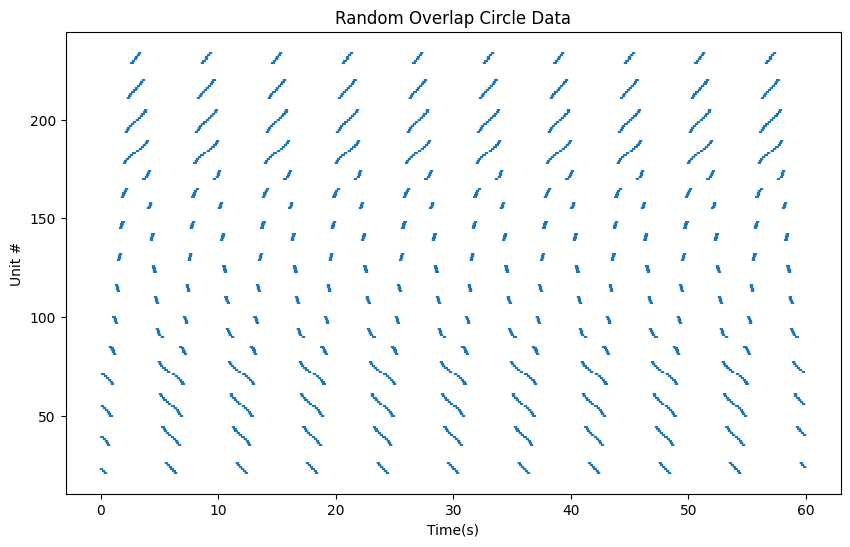

In [49]:
plot_raster(continuous_overlap_spike_data, "Random Overlap Circle Data")

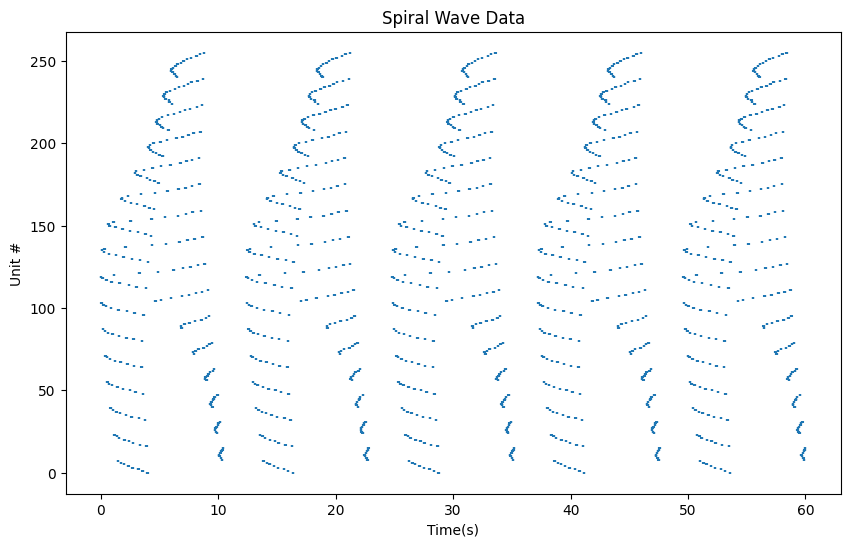

In [82]:
plot_raster(spiral_wave_spike_data, "Spiral Wave Data")

In [80]:
# Save the spikedata with pickle
with open('data/spiral_wave_spike_data.pkl', 'wb') as f:
    pickle.dump(spiral_wave_spike_data, f)

In [40]:
# Save the spikedata with pickle
with open('data/continuous_loop_overlap_spike_data.pkl', 'wb') as f:
    pickle.dump(continuous_overlap_spike_data, f)